# Simulation Tutorial

This notebook shows how to estimate the delay and amplitude response between primary brain regions for a given neuron.  In general, the delay within a compartment tends to be isopotential meaning a region to region response matrix is a reasonable characterization of the output response of a neuron.

The electrical simulation uses a simple linear passive model using a network of resistors and capacitors based on a skeleton representation of the neuron.  Users can specify specific membrane resistance and capacitance values and cytoplasm resitance.

**Note:** You must install some additional dependencies before using simulation functions:

```
conda install -c conda-forge ngspice umap-learn scikit-learn matplotlib
```

## Setup neuron model

* create neuprint client using the public hemibrain dataset
* build a neuron spice model for a given body id

In [2]:
from neuprint import Client

TOKEN = "" # <--- Paste your token here
           # (or define NEUPRINT_APPLICATION CREDENTIALS in your environment)

client = Client("neuprint.janelia.org", "hemibrain:v1.0.1", TOKEN)

In [3]:
# simulate a PEG neuron (same type as in hemibrain paper)
from neuprint import NeuronModel
nm = NeuronModel(449438847)

## Estimate neuron timing

### Run simulation for the given neuron

Specify the number of inputs per brain region (randomly selected) which will be tested.  A current is injected at each input site one at a time and delay and amplitude response is measured.

In [4]:
res = nm.simulate(2)

### Examine the response results

compute_region_delay_matrix reports the delay between regions where the row index is the input brain region and the column names represent the output region.  A delay (ms) and amplitude (mV) are returned.  They are averages over all the response for a given region input-output pair.

Note: the results to synapses that are not in brain regions ("none") are shown for completeness.  But those output responses are not necessarily co-located and cannot be treated as an ROI.

In [5]:
delay, amp = res.compute_region_delay_matrix()

In [6]:
# delay matrix in ms
delay

,EB,LAL(R),PB,none
CRE(R),2.074233,0.427321,3.208169,2.539196
EB,1.267612,2.479685,3.188025,2.505964
FB,1.827776,2.283533,1.432143,0.579180
LAL(R),2.429247,0.300181,3.545004,2.880766
PB,3.146916,3.552974,0.473219,0.713720
none,2.528454,2.951348,0.702518,0.131596


In [7]:
# amplitude in mV
amp

,EB,LAL(R),PB,none
CRE(R),0.153407,0.489385,0.122230,0.134334
EB,0.184613,0.145412,0.123035,0.135454
FB,0.153325,0.143585,0.168316,0.194255
LAL(R),0.145020,0.836957,0.115879,0.127300
PB,0.123349,0.116553,0.406416,0.261447
none,0.135605,0.127879,0.272352,0.319946


### Plot response from one brain region to others

Each dot represents the response from each input from the specified input region (LAL(R) here) to every output in the neuron (each output brain region is indicated).

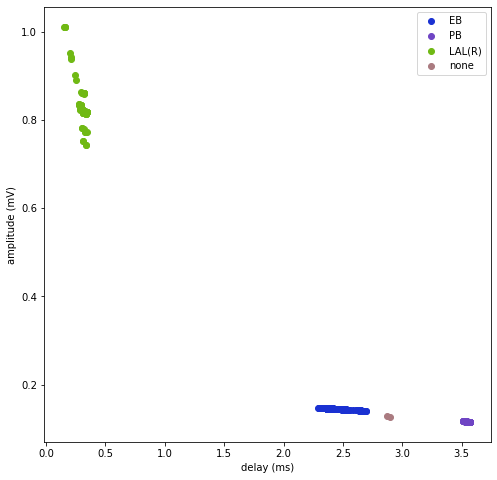

In [8]:
res.plot_response_from_region("LAL(R)")

## Decompose neuron connections by electrical domain

Use simple linear passive delay progragation through the neuron to determine distinct domains for representing the neuron.  The decomposition can be used to derive ROIs using electrical delay.

### Simulate the delay 'distances' between parts of the neuron

This function checks propagation delays throughout the neuron based on the number of specified points.  The points are randomly chosen even between inputs and outputs.  In principle, any points could be chosen.

In [21]:
res = nm.estimate_intra_neuron_delay(num_points=100)

### Show delay propogation closeness between simulated points

This plot should show whether there are distinct electrical domains for the neuron.  The primary ROI labels are provided to show how well the points correspond to the annotated regions.

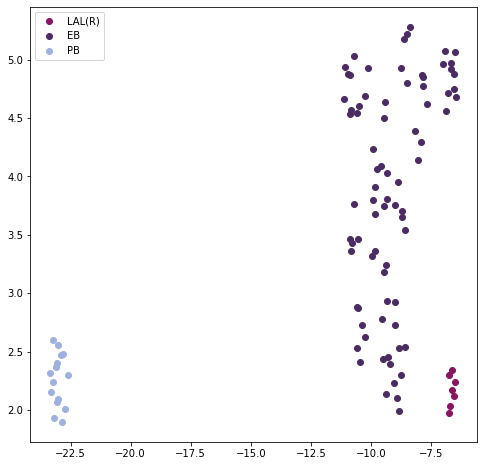

In [22]:
res.plot_neuron_domains()

### Partition the neuron into different domains based on simulated points

Cluster the simulated points and map a partition id to each synapse in the neuron.  The function returns input and output connections broken down by these domain ids. 

In [23]:
summary, detailed_io, plot = res.estimate_neuron_domains(3, plot=True)

In [24]:
# input / output table broken down by domain id from partitioning
summary

,io,partner,weight,domain_id,rois
0,output,696682163,147,1,[EB]
1,output,974300015,97,2,"[PB, none]"
2,output,858587718,88,1,[EB]
3,output,858587718,72,0,[LAL(R)]
4,output,1228692168,66,1,[EB]
...,...,...,...,...,...
720,input,5813057963,1,1,[EB]
721,input,5813062805,1,0,[CRE(R)]
722,input,5813061383,1,2,[PB]
723,input,5813070465,1,1,[EB]


In [25]:
# domain id for each x,y,z location
detailed_io

,type,x,y,z,roi,partner,domain_id
0,post,21510,26069,20648,EB,387364605,1
1,post,23679,24857,20538,EB,387364605,1
2,post,22135,26177,20494,EB,387364605,1
3,post,21613,25974,20679,EB,387364605,1
4,post,23870,23196,20455,EB,387364605,1
...,...,...,...,...,...,...,...
7092,pre,23030,24895,20167,EB,1002507131,1
7093,pre,23621,24908,20429,EB,1002507131,1
7094,pre,22615,24507,19708,EB,1002507131,1
7095,pre,22992,24888,20123,EB,1002507131,1


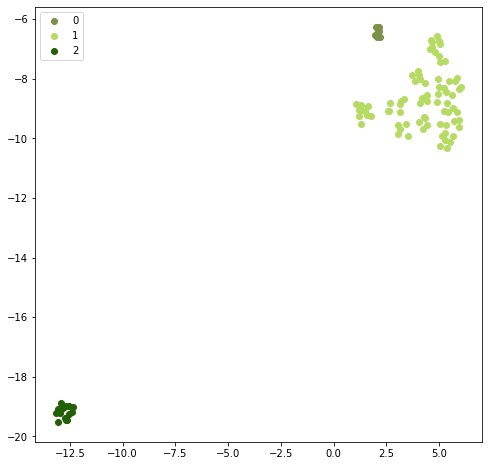

In [26]:
plot